In [2]:
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

Using cache found in /home/salih/.cache/torch/hub/facebookresearch_dinov2_main


image1.shape: (568, 700, 3)
mask1.shape: (568, 700)
image_tensor1.shape: torch.Size([3, 448, 546])
grid_size1: (32, 39)
resize_scale1: 1.2681159420289856


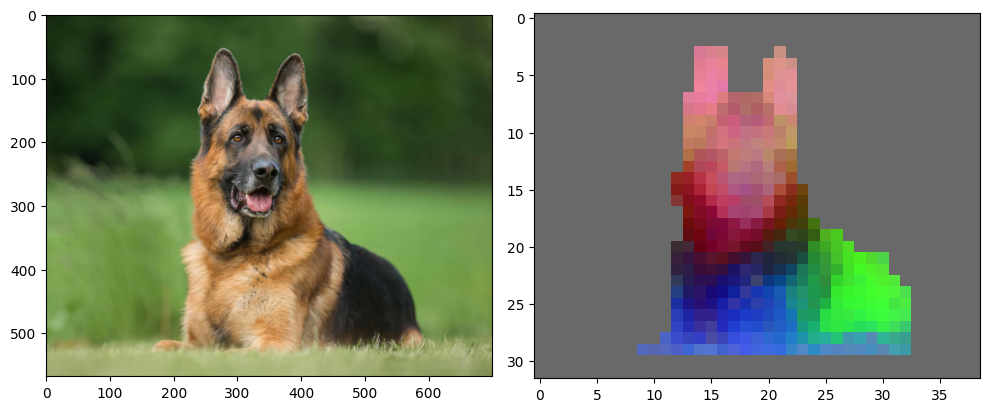

In [7]:
class Dinov2Matcher:

  def __init__(self, repo_name="facebookresearch/dinov2", model_name="dinov2_vitb14", smaller_edge_size=448, half_precision=False, device="cuda"):
    self.repo_name = repo_name
    self.model_name = model_name
    self.smaller_edge_size = smaller_edge_size
    self.half_precision = half_precision
    self.device = device

    if self.half_precision:
      self.model = torch.hub.load(repo_or_dir=repo_name, model=model_name).half().to(self.device)
    else:
      self.model = torch.hub.load(repo_or_dir=repo_name, model=model_name).to(self.device)

    self.model.eval()

    self.transform = transforms.Compose([
        transforms.Resize(size=smaller_edge_size, interpolation=transforms.InterpolationMode.BICUBIC, antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # imagenet defaults
      ])

  # https://github.com/facebookresearch/dinov2/blob/255861375864acdd830f99fdae3d9db65623dafe/notebooks/features.ipynb
  def prepare_image(self, rgb_image_numpy):
    image = Image.fromarray(rgb_image_numpy)
    image_tensor = self.transform(image)
    resize_scale = image.width / image_tensor.shape[2]

    # Crop image to dimensions that are a multiple of the patch size
    height, width = image_tensor.shape[1:] # C x H x W
    cropped_width, cropped_height = width - width % self.model.patch_size, height - height % self.model.patch_size # crop a bit from right and bottom parts
    image_tensor = image_tensor[:, :cropped_height, :cropped_width]

    grid_size = (cropped_height // self.model.patch_size, cropped_width // self.model.patch_size)
    return image_tensor, grid_size, resize_scale
  
  def prepare_mask(self, mask_image_numpy, grid_size, resize_scale):
    cropped_mask_image_numpy = mask_image_numpy[:int(grid_size[0]*self.model.patch_size*resize_scale), :int(grid_size[1]*self.model.patch_size*resize_scale)]
    image = Image.fromarray(cropped_mask_image_numpy)
    resized_mask = image.resize((grid_size[1], grid_size[0]), resample=Image.Resampling.NEAREST)
    resized_mask = np.asarray(resized_mask).flatten()
    return resized_mask
  
  def extract_features(self, image_tensor):
    with torch.inference_mode():
      if self.half_precision:
        image_batch = image_tensor.unsqueeze(0).half().to(self.device)
      else:
        image_batch = image_tensor.unsqueeze(0).to(self.device)

      tokens = self.model.get_intermediate_layers(image_batch)[0].squeeze()
    return tokens.cpu().numpy()
  
  def idx_to_source_position(self, idx, grid_size, resize_scale):
    row = (idx // grid_size[1])*self.model.patch_size*resize_scale + self.model.patch_size / 2
    col = (idx % grid_size[1])*self.model.patch_size*resize_scale + self.model.patch_size / 2
    return row, col
  
  def get_embedding_visualization(self, tokens, grid_size, resized_mask=None):
    pca = PCA(n_components=3)
    if resized_mask is not None:
      tokens = tokens[resized_mask]
    reduced_tokens = pca.fit_transform(tokens.astype(np.float32))
    if resized_mask is not None:
      tmp_tokens = np.zeros((*resized_mask.shape, 3), dtype=reduced_tokens.dtype)
      tmp_tokens[resized_mask] = reduced_tokens
      reduced_tokens = tmp_tokens
    reduced_tokens = reduced_tokens.reshape((*grid_size, -1))
    normalized_tokens = (reduced_tokens-np.min(reduced_tokens))/(np.max(reduced_tokens)-np.min(reduced_tokens))
    return normalized_tokens

# Load image and mask
image1 = cv2.cvtColor(cv2.imread('asd1.jpg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
mask1 = cv2.imread('asd1_mask.jpg', cv2.IMREAD_COLOR)[:,:,0] > 127

# Init Dinov2Matcher
dm = Dinov2Matcher(half_precision=False)

# Extract features
image_tensor1, grid_size1, resize_scale1 = dm.prepare_image(image1)
features1 = dm.extract_features(image_tensor1)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,20))
ax1.imshow(image1)
resized_mask = dm.prepare_mask(mask1, grid_size1, resize_scale1)
vis_image = dm.get_embedding_visualization(features1, grid_size1, resized_mask)
ax2.imshow(vis_image)
fig.tight_layout()

# More info
print("image1.shape:", image1.shape)
print("mask1.shape:", mask1.shape)
print("image_tensor1.shape:", image_tensor1.shape)
print("grid_size1:", grid_size1)
print("resize_scale1:", resize_scale1)

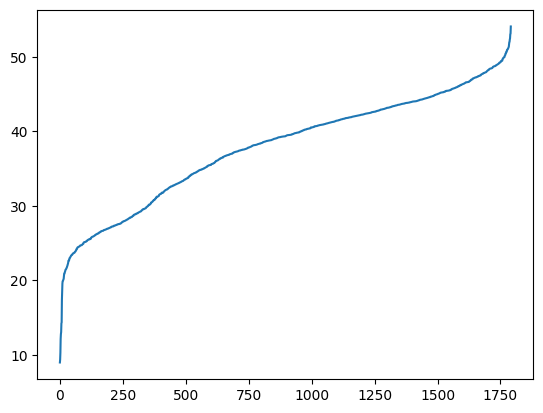

In [8]:
# Extract image1 features
image1 = cv2.cvtColor(cv2.imread('asd1.jpg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
mask1 = cv2.imread('asd1_mask.jpg', cv2.IMREAD_COLOR)[:,:,0] > 127
image_tensor1, grid_size1, resize_scale1 = dm.prepare_image(image1)
features1 = dm.extract_features(image_tensor1)

# Extract image2 features
image2 = cv2.cvtColor(cv2.imread('asd2.jpg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
mask2 = cv2.imread('asd2_mask.jpg', cv2.IMREAD_COLOR)[:,:,0] > 127
image_tensor2, grid_size2, resize_scale2 = dm.prepare_image(image2)
features2 = dm.extract_features(image_tensor2)

# Build knn using features from image1, and query all features from image2
knn = NearestNeighbors(n_neighbors=1)
knn.fit(features1)
distances, match2to1 = knn.kneighbors(features2)
match2to1 = np.array(match2to1)

plt.plot(sorted(distances))

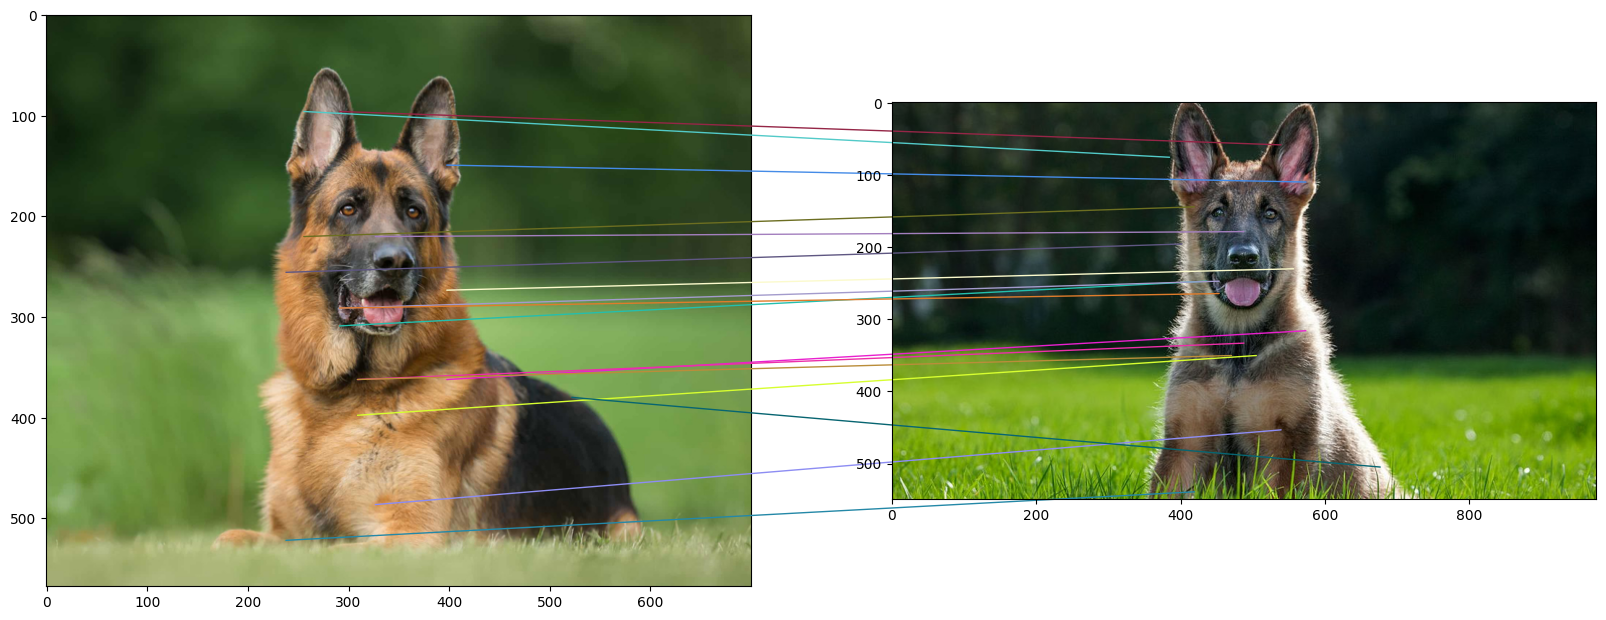

In [14]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(image1)
ax2.imshow(image2)

for idx2, (dist, idx1) in enumerate(zip(distances, match2to1)):
  row, col = dm.idx_to_source_position(idx1, grid_size1, resize_scale1)
  xyA = (col, row)
  if not mask1[int(row), int(col)]: continue # skip if feature is not on the object

  row, col = dm.idx_to_source_position(idx2, grid_size2, resize_scale2)
  xyB = (col, row)
  if not mask2[int(row), int(col)]: continue # skip if feature is not on the object

  if np.random.rand() > 0.05: continue # sparsely draw so that we can see the lines...

  con = ConnectionPatch(xyA=xyB, xyB=xyA, coordsA="data", coordsB="data",
                        axesA=ax2, axesB=ax1, color=np.random.rand(3,))
  ax2.add_artist(con)
